In [ ]:
import numpy as np # linear algebra
import os
import glob
import torch
import torch.utils.data as data
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pytorch_lightning as pl
pl.seed_everything(42)
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
%load_ext tensorboard
from torchvision.datasets import ImageFolder
from copy import deepcopy
import torchvision.models as models
from os                import listdir, makedirs, getcwd, remove
from os.path           import isfile, join, abspath, exists, isdir, expanduser

In [1]:
!zip -r exercise_data.zip /kaggle/input/ammi-2023-convnets

Scanning files  ...
  adding: kaggle/input/ammi-2023-convnets/ (stored 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/ (stored 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/extraimages/ (stored 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/extraimages/extra-image-9351.jpg (deflated 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/extraimages/extra-image-430.jpg (deflated 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/extraimages/extra-image-14967.jpg (deflated 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/extraimages/extra-image-14936.jpg (deflated 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/extraimages/extra-image-4047.jpg (deflated 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/extraimages/extra-image-9063.jpg (deflated 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/extraimages/extra-image-9331.jpg (deflated 0%)
  adding: kaggle/input/ammi-2023-convnets/extraimages/extraimages/extra

In [7]:
CHECKPOINT_PATH="/kaggle/working"

In [8]:
# Data augemntation
class TransformImages(object):
    def __call__(self, x):
        return [transforms.Compose([transforms.RandomHorizontalFlip(),transforms.transforms.RandomResizedCrop(224),transforms.RandomApply([transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)],p=0.6),
        transforms.RandomGrayscale(p=0.2),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])(x) for i in range(2)]

class ValidationTransformImages(object):
    def __call__(self, x):
        return [transforms.Compose([transforms.RandomResizedCrop(size=224),transforms.GaussianBlur(kernel_size=3),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])(x) for i in range(2)]

In [9]:
class LocalImageLoader(Dataset):
    def __init__(self, data_dir:str, validation=False):
        self.source_dir = data_dir
        self.data_dirs = os.listdir(self.source_dir)
        if validation:
            self.transform= ValidationTransformImages()
        else:
            self.transform = TransformImages()

    def __getitem__(self, index):
        image = Image.open(f"{self.source_dir}/{self.data_dirs[index]}").convert('RGB')
        images = self.transform(image)
        return images
    def get_filename(self, index):
        return f"{self.source_dir}/{self.data_dirs[index]}"
    
    def get_by_filename(self, filename):
        image = Image.open(filename)
        images = self.transform(image)
        return images

    def __len__(self):
        return len(self.data_dirs)

In [10]:
unlabeledDataset = LocalImageLoader("/kaggle/input/ammi-2023-convnets/extraimages/extraimages")
validationDataset = LocalImageLoader("/kaggle/input/ammi-2023-convnets/test/test/0",True)

In [11]:
dataloader = data.DataLoader(unlabeledDataset, batch_size=64, shuffle=True, drop_last=False)

validationDataloader = data.DataLoader(validationDataset, batch_size=64, shuffle=True, drop_last=False)

torch.Size([3, 224, 224])
2 64 <class 'torch.Tensor'> torch.Size([3, 224, 224])
torch.Size([128, 3, 224, 224])


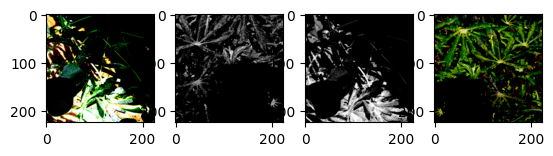

In [12]:
iterator = iter(dataloader)
images = next(iterator)
print(images[0][0].shape)
print(len(images), len(images[0]), type(images[0]), images[0][0].shape)
aa, axis = plt.subplots(1, 4)
axis[0].imshow(np.transpose(images[0][0].numpy(), (1, 2, 0)))
axis[1].imshow(np.transpose(images[0][1].numpy(), (1, 2, 0)))
axis[2].imshow(np.transpose(images[1][0].numpy(), (1, 2, 0)))
axis[3].imshow(np.transpose(images[1][1].numpy(), (1, 2, 0)))

imgs = torch.cat(images, dim=0)
print(imgs.shape)

In [13]:
print(len(images[1]))
print(images[1].shape)

64
torch.Size([64, 3, 224, 224])


In [14]:
class CasavaDiseaseDetectionSimCLR(pl.LightningModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        self.count =0
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        self.convnet = torchvision.models.resnet34(pretrained=True)  # Output of last linear layer
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,
            nn.ReLU(inplace=True),
            nn.Linear(1000, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]
    
    def forward(self, datas):
        out= self.convnet(out)
        out = self.fc(datas)
        return out

    def info_nce_loss(self, imgs, mode='train'):
        imgs = torch.cat(imgs, dim=0)
        feats = self.convnet(imgs)
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())
        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        if batch_idx >0 and batch_idx % 28==0:
            self.count += 1
            torch.save(self.state_dict(), f'pre_trained_model_{self.count}.ckpt')
        self.info_nce_loss(batch, mode='val')

In [17]:
def train_simclr(batch_size, max_epochs=500,**kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'CasavaDetection'),
                          devices=1,
                          max_epochs=max_epochs,
                          callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')])
    trainer.logger._default_hp_metric = None
    pretrained_filename = os.path.join(CHECKPOINT_PATH+"/CasavaDetection/", 'CasavaDetection.ckpt')
    print("A: ", CHECKPOINT_PATH+"/CasavaDetection/"+ 'CasavaDetection.ckpt')
    if os.path.isfile(pretrained_filename):
        model = CasavaDiseaseDetectionSimCLR.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42) # To be reproducable
        model = CasavaDiseaseDetectionSimCLR.load_from_checkpoint("/kaggle/input/friday-model/my_model.ckpt") # Load best checkpoint after training
#         model = CasavaDiseaseDetectionSimCLR(max_epochs=max_epochs, hidden_dim=128,lr=5e-4,temperature=0.07,weight_decay=1e-4)
        trainer.fit(model, dataloader, validationDataloader)
#         print("trainer.checkpoint_callback.best_model_path:", trainer.checkpoint_callback.best_model_path)
#         model = CasavaDiseaseDetectionSimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path) # Load best checkpoint after training
    return model

In [18]:
train_simclr(batch_size=128,hidden_dim=128,lr=5e-3,temperature=0.07,weight_decay=1e-4,max_epochs=30)

A:  /kaggle/working/CasavaDetection/CasavaDetection.ckpt


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

CasavaDiseaseDetectionSimCLR(
  (convnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [38]:
!cp /kaggle/working/CasavaDetection/lightning_logs/version_3/checkpoints/epoch=12-step=2561.ckpt /kaggle/working/CasavaDetection/

In [ ]:
!touch /kaggle/working/newmodel.ckpt
!cp /kaggle/working/CasavaDetection/lightning_logs/version_2/checkpoints/epoch=4-step=985.ckpt /kaggle/working/newmodel.ckpt

In [ ]:
model= CasavaDiseaseDetectionSimCLR.load_from_checkpoint("/kaggle/working/CasavaDetection/lightning_logs/version_0/checkpoints/epoch=2-step=591.ckpt")

In [ ]:
model= CasavaDiseaseDetectionSimCLR.load_from_checkpoint("/kaggle/working/CasavaDetection/lightning_logs/version_2/checkpoints/epoch=4-step=985.ckpt")

In [82]:
transformation = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [83]:
augment_transform=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.transforms.RandomResizedCrop(224),transforms.ToTensor(),transforms.RandomApply([transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.1)],p=0.6), transforms.RandomGrayscale(p=0.2),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [84]:
class LogisticClassifier(pl.LightningModule):
    
    def __init__(self, preTrainedModelPath, feature_dim, num_classes, lr, weight_decay, max_epochs=30):# feature_classes, num_classes, lr, weight_decay, max_epochs=30, feature_dim=None):
        super().__init__()
#         modelCopy = deepcopy(CasavaDiseaseDetectionSimCLR.load_from_checkpoint(preTrainedModelPath))
        if os.path.isfile(preTrainedModelPath):
            print("------------- Using pre-trained model path -------------------------")
            modelCopy = deepcopy(CasavaDiseaseDetectionSimCLR.load_from_checkpoint(pretrained_filename)).convnet
        else:
            print("------------- Using New SIMCLR model path -------------------------")
            pl.seed_everything(42) # To be reproducable
            modelCopy = CasavaDiseaseDetectionSimCLR(max_epochs=max_epochs, hidden_dim=128,lr=5e-4,temperature=0.07,weight_decay=1e-4).convnet
        self.save_hyperparameters()
        self.pre_trained= modelCopy # models.resnet18(pretrained=True)  # Output of last linear layer
        self.pre_trained.fc = nn.Sequential(
            self.pre_trained.fc,
            nn.ReLU(inplace=True),
            nn.Linear(128, feature_dim)
        )
        self.convnet =nn.Sequential(
                        nn.Linear(feature_dim, 64),
                        nn.ReLU(),
                        nn.ReLU(),
                        nn.Linear(64,32),
                        nn.ReLU(),
                        nn.Linear(32,num_classes))
        self.data_used = 0
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                  milestones=[int(self.hparams.max_epochs*0.6),
                                                              int(self.hparams.max_epochs*0.8)],
                                                  gamma=0.1)
        return [optimizer], [lr_scheduler]
    def forward(self, input_data):
        return self.pre_trained(self.convnet(input_data[0]))
    
    def CrossEntropyLoss(self, batch, mode="train"):
        datas, labels = batch
        self.data_used+= datas.shape[0]* datas.shape[1]
        out= self.pre_trained(datas)
        prediction = self.convnet(out)
        loss = F.cross_entropy(prediction, labels)
        accuracy = (prediction.argmax(dim=-1)==labels).float().mean()
        self.log(mode + '_loss', loss)
        self.log(mode + '_acc', accuracy)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self.CrossEntropyLoss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.CrossEntropyLoss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self.CrossEntropyLoss(batch, mode="test")

In [85]:
classification_training_dataset= ImageFolder(root="/kaggle/input/ammi-2023-convnets/train/train", transform=transformation)
classification_test_dataset= ImageFolder(root="/kaggle/input/ammi-2023-convnets/test/test", transform=transformation)

In [86]:
# classifierModel = LogisticClassifier(model,128, 5, 1e-2, 1e-2)
# classifierModel

In [87]:
from tqdm.notebook import tqdm
@torch.no_grad()
def getPretrainedOutputForLabeledData(model, dataset, training=False):
    modelCopy = deepcopy(model)
    modelCopy.fc = nn.Identity()
    modelCopy.eval()
    
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle = training)
    pretrainedPredictions, labels = [], []
    for data, label in tqdm(dataloader):
        prediction=modelCopy.forward(data)
        pretrainedPredictions.append(prediction)
        labels.append(label)
    pretrainedPredictions = torch.cat(pretrainedPredictions, dim=0)
    labels = torch.cat(labels, dim=0)

    labels, idxs = labels.sort()
    pretrainedPredictions = pretrainedPredictions[idxs]

    return torch.utils.data.TensorDataset(pretrainedPredictions, labels)

In [ ]:
def train_logreg(preTrainedModelPath, batch_size, train_feats_data, test_feats_data, model_suffix, max_epochs=20, **kwargs):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc'),
                                    LearningRateMonitor("epoch")],
                         enable_progress_bar=False,)
#                          check_val_every_n_epoch=10)
    trainer.logger._default_hp_metric = None
    # Data loaders
    classification_train_loader = torch.utils.data.DataLoader(classification_training_dataset, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=8)
    classification_test_loader = torch.utils.data.DataLoader(classification_test_dataset, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=8)

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt")
#     if os.path.isfile(pretrained_filename):
#         print(f"Found pretrained model at {pretrained_filename}, loading...")
#         model = LogisticClassifier.load_from_checkpoint(pretrained_filename)
#     else:
    pl.seed_everything(42)  # To be reproducable
    classificationModel = LogisticClassifier(preTrainedModelPath, **kwargs)
    trainer.fit(classificationModel, classification_train_loader, classification_test_loader)
    classificationModel = LogisticClassifier.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # Test best model on train and validation set
    train_result = trainer.test(classificationModel, classification_train_loader, verbose=True)
    test_result = trainer.test(classificationModel, classification_test_loader, verbose=True)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}
    return classificationModel, result

In [ ]:
results = {}
final_model = None
# for num_imgs_per_label in [50, 100]:
#     sub_train_set = get_smaller_dataset(classification_training_dataset, num_imgs_per_label)
final_model, small_set_results = train_logreg("/kaggle/working/CasavaDetection/lightning_logs/version_2/checkpoints/epoch=4-step=985.ckpt",
                                                batch_size=64,
                                                train_feats_data=classification_training_dataset,
                                                test_feats_data= classification_test_dataset,
                                                model_suffix=50,
                                                feature_dim=128,#classification_training_dataset.tensors[0].shape[1],
                                                num_classes=5,
                                                lr=1e-2,
                                                weight_decay=1e-3)
results[num_imgs_per_label] = small_set_results

In [ ]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6,4))
plt.plot(dataset_sizes, test_scores,marker=".", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("imagewang classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

print(f'Images/label   Accuracy(%)')
for k, score in zip(dataset_sizes, test_scores):
    print(f'{k:3d}            {100*score:4.2f}%')

In [88]:
class LogisticClassifierM(nn.Module):
    
    def __init__(self, model=None,num_classes=5,preTrainedModelPath=None ):# feature_classes, num_classes, lr, weight_decay, max_epochs=30, feature_dim=None):
        super(LogisticClassifierM, self).__init__()
        modelCopy=None
        if os.path.isfile(preTrainedModelPath):
            print("------------- Using pre-trained model path -------------------------")
            modelCopy = deepcopy(CasavaDiseaseDetectionSimCLR.load_from_checkpoint(preTrainedModelPath)).convnet
        else:
            print("------------- Using New SIMCLR model path -------------------------")
            pl.seed_everything(42) # To be reproducable
            modelCopy = CasavaDiseaseDetectionSimCLR(hidden_dim=128,lr=5e-4,temperature=0.07,weight_decay=1e-4).convnet
        self.convnet= modelCopy # models.resnet18(pretrained=True)  # Output of last linear layer
        self.convnet.fc = nn.Sequential(
            self.convnet.fc, 
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,num_classes))
        self.data_used = 0

    def forward(self, input_data):
        return self.convnet(input_data)
#         self.CrossEntropyLoss(batch, mode="test")

In [134]:
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None, augment_transform= None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform
        self.augment_transform=augment_transform

        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None

    def __len__(self):
        return 2* len(self.file_list) if self.augment_transform else len(self.file_list)

    def __getitem__(self, idx):
        im = None
        if self.augment_transform:
            fileName = self.file_list[idx//2][2]
            classCategory = self.file_list[idx//2][0]
            im = Image.open(fileName)
            if idx%2 == 1:
                im = self.augment_transform(im)
            else:
                im = self.transform(im)
        else:
            fileName = self.file_list[idx][2]
            classCategory = self.file_list[idx][0]
            im = Image.open(fileName)
            if self.transform:
                im = self.transform(im)
        return im.view(3, 224, 224), classCategory

In [135]:
data_path = "/kaggle/input/ammi-2023-convnets/"
train_path = join(data_path, "train/train")
test_path = join(data_path,"test/test")
extraimage_path = join(data_path, "extraimages/extraimages")

In [136]:
LABELED_WORKING_DIRECTORY ="/kaggle/working/labeled"

In [147]:
train_data = CassavaDataset(train_path, transform=transformation)#, augment_transform=augment_transform)
test_data = CassavaDataset(test_path, transform=transformation)

In [148]:
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [149]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                             sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=32,
                                             sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32)

In [150]:
trainIter = iter(train_loader)
data = next(trainIter)
print(data[0].shape)

torch.Size([32, 3, 224, 224])


In [141]:
classification_train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True,
                                                          drop_last=False, pin_memory=True, num_workers=8)
classification_test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False,
                                                         drop_last=False, pin_memory=True, num_workers=8)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [151]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [157]:
model = LogisticClassifierM(5, preTrainedModelPath="/kaggle/input/friday-model/my_model.ckpt")

------------- Using pre-trained model path -------------------------


In [177]:
# model

In [166]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [167]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model.""" 
    
    # Make sure model is in training mode.
    model.train()
    
    # Move model to the device (CPU or GPU).
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None

    print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):
        print("Learning rate: ", optimizer.param_groups[0]['lr'])
        if epoch % 6==0 and epoch >0:
            optimizer.param_groups[0]['lr']=optimizer.param_groups[0]['lr']/6
        # Loop over data.
        for batch_idx, (features, target) in enumerate(data_loader):
          # Forward pass.
            output = model(features.to(device))
            loss = criterion(output.to(device), target.to(device))
              # Backward pass.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # NOTE: It is important to call .item() on the loss before summing.
            if ema_loss is None:
                ema_loss = loss.item()
            else:
                ema_loss += (loss.item() - ema_loss) * 0.01 

        # Print out progress the end of epoch.
        print('Epoch: {} \tLoss: {:.6f}'.format(epoch, ema_loss),)

In [168]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        # Loop over test data.
        for features, target in data_loader:
          
            # Forward pass.
            output = model(features.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(valid_sampler)
    print(f'Test accuracy: {correct} / {len(valid_sampler)} ({percent:.0f}%)')
    torch.save(model.state_dict(), 'model.ckpt')
    return percent

In [171]:
num_epochs = 3
train(model, criterion, train_loader, optimizer, num_epochs=num_epochs)

----- Training Loop -----
Learning rate:  0.01
Epoch: 0 	Loss: 0.632105
Learning rate:  0.01
Epoch: 1 	Loss: 0.558219
Learning rate:  0.01
Epoch: 2 	Loss: 0.505048


In [ ]:
test(model, valid_loader)

#### Labeling the unlabeled data and training

In [192]:
# !rm -r /kaggle/working/unlabeleds
!rm -r /kaggle/working/labeled

In [49]:
# Copy all the unlabeled datas into the working directory 
!mkdir -p /kaggle/working/unlabeleds
!cp -r /kaggle/input/ammi-2023-convnets/extraimages/extraimages /kaggle/working/unlabeleds

In [50]:
# make labeled directories
!mkdir -p /kaggle/working/labeled
!mkdir -p /kaggle/working/labeled/cmd
!mkdir -p /kaggle/working/labeled/cbb
!mkdir -p /kaggle/working/labeled/cbsd
!mkdir -p /kaggle/working/labeled/healthy
!mkdir -p /kaggle/working/labeled/cgm

In [55]:
unlabeledDataset = LocalImageLoader("/kaggle/working/unlabeleds/extraimages",True)

In [56]:
unlabaled_dataloader = torch.utils.data.DataLoader(unlabeledDataset, batch_size=1)

In [57]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [59]:
predictionClassMap = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}

def labelingUnlabeledData(model, data_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    confidence_threshold=0.95
    print('----- Migration Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        # Loop over test data.
        count=0
        for index, (features, target) in enumerate(data_loader):
#             print(index, unlabeledDataset.get_filename(index))
            # Forward pass.
            output = model(features.to(device))
            # Calculating the probability of each logits using softmax function
            output=output.squeeze()
            probabilities = torch.exp(output) / torch.sum(torch.exp(output))
            
            # Get the numerical values of the probabilities
            numerical_values = probabilities.tolist()
            
            # Assuming probs is a list of probabilities obtained from the softmax function
            max_probability = max(numerical_values)
            if max_probability >= confidence_threshold:
                class_label = torch.argmax(probabilities)  # Get the index of the highest probability
                if not os.path.exists(f"/kaggle/working/labeled/{predictionClassMap[class_label.item()]}/"+str.split(unlabeledDataset.get_filename(index), "/")[-1]):
                    torchvision.utils.save_image(features.squeeze(), f"/kaggle/working/labeled/{predictionClassMap[class_label.item()]}/"+str.split(unlabeledDataset.get_filename(index), "/")[-1])
                if os.path.exists(unlabeledDataset.get_filename(index)):
                    os.remove(unlabeledDataset.get_filename(index))
            
labelingUnlabeledData(model,unlabaled_dataloader)

----- Migration Evaluation -----


In [ ]:
predictionClassMap = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}

def labelingUnlabeledData(model, data_loader):
    """Measures the accuracy of a model on a data set.""" 
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    confidence_threshold=0.95
    print('----- Migration Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():
        # Loop over test data.
        count=0
        for index, (features, target) in enumerate(data_loader):
#             print(index, unlabeledDataset.get_filename(index))
            # Forward pass.
            output = model(features.to(device))
            # Calculating the probability of each logits using softmax function
            output=output.squeeze()
            probabilities = torch.exp(output) / torch.sum(torch.exp(output))
            
            # Get the numerical values of the probabilities
            numerical_values = probabilities.tolist()
            
            # Assuming probs is a list of probabilities obtained from the softmax function
            max_probability = max(numerical_values)
            if max_probability >= confidence_threshold:
                class_label = torch.argmax(probabilities)  # Get the index of the highest probability
                if not os.path.exists(f"/kaggle/working/labeled/{predictionClassMap[class_label.item()]}/"+str.split(unlabeledDataset.get_filename(index), "/")[-1]):
                    torchvision.utils.save_image(features.squeeze(), f"/kaggle/working/labeled/{predictionClassMap[class_label.item()]}/"+str.split(unlabeledDataset.get_filename(index), "/")[-1])
#                if os.path.exists(unlabeledDataset.get_filename(index)):
#                    os.remove(unlabeledDataset.get_filename(index))
            
labelingUnlabeledData(model,unlabaled_dataloader)

In [64]:
!ls -l /kaggle/working/labeled/cbb/ | grep "^-" | wc -l

0


In [359]:
!zip -r my_labeled.zip /kaggle/working/labeled

updating: kaggle/working/labeled/ (stored 0%)
updating: kaggle/working/labeled/cgm/ (stored 0%)
updating: kaggle/working/labeled/cgm/extra-image-7632.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/extra-image-7801.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/extra-image-13665.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/extra-image-9210.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/extra-image-6872.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/extra-image-2977.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/extra-image-6332.jpg (deflated 2%)
updating: kaggle/working/labeled/cgm/extra-image-4491.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/extra-image-14972.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/extra-image-18.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/extra-image-2342.jpg (deflated 2%)
updating: kaggle/working/labeled/cgm/extra-image-12566.jpg (deflated 1%)
updating: kaggle/working/labeled/cgm/ex

In [337]:
!ls -l /kaggle/input/ammi-2023-convnets/train/train/healthy/ | grep "^-" | wc -l

316


In [355]:
import tqdm

def predict(model, loader):
    model.eval()
    model.to(device)
    
    test_dataloader =  loader
    preds = []
    
    for test_images,test_labels in (classification_test_loader):
        #print(test_images)
        test_images = test_images.to(device)
        #test_labels = test_labels.to(device)
      
        output = model(test_images)
    

        _, predicted = torch.max(output, 1)
        preds.extend(predicted.cpu().data.numpy())
        
        
    return preds

In [356]:
name = [test_data.file_list[i][-1].split('/')[-1] for i in range(len(test_data.file_list)) ]

In [358]:
import pandas as pd

#sample = pd.read_csv('/kaggle/input/ammi-2023-convnets/sample_submission_file.csv')
sample=pd.DataFrame()

preds = predict(model, test_loader)
mapping = {0: 'cmd', 1: 'cbb', 2: 'cbsd', 3: 'healthy', 4: 'cgm'}
new_preds = [mapping[pred] for pred in preds]
sample['Category'] = new_preds
sample['Id'] = name
sample.to_csv('test_prediction_final.csv', index=False)
sample.head()

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


,Category,Id
0,cmd,test-img-1448.jpg
1,cgm,test-img-768.jpg
2,cgm,test-img-3481.jpg
3,cmd,test-img-1475.jpg
4,cgm,test-img-2498.jpg
